<a href="https://www.kaggle.com/code/vijayasathvika/tb-vgg-16?scriptVersionId=260865494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.7068 - loss: 5.9723 - val_accuracy: 0.9512 - val_loss: 1.5409
Epoch 2/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.8417 - loss: 2.8243 - val_accuracy: 0.9536 - val_loss: 1.4044
Epoch 3/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.8578 - loss: 2.2031 - val_accuracy: 0.9226 - val_loss: 1.3784
Epoch 4/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8656 - loss: 1.8036 - val_accuracy: 0.9560 - val_loss: 1.2993
Epoch 5/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.8680 - loss: 1.7365 - val_accuracy: 0.9429 - val_loss: 1.3123
Epoch 6/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.8876 - loss: 1.6199 - val_accuracy: 0.9595 - val_loss: 1.2553
Epoch 7/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 1

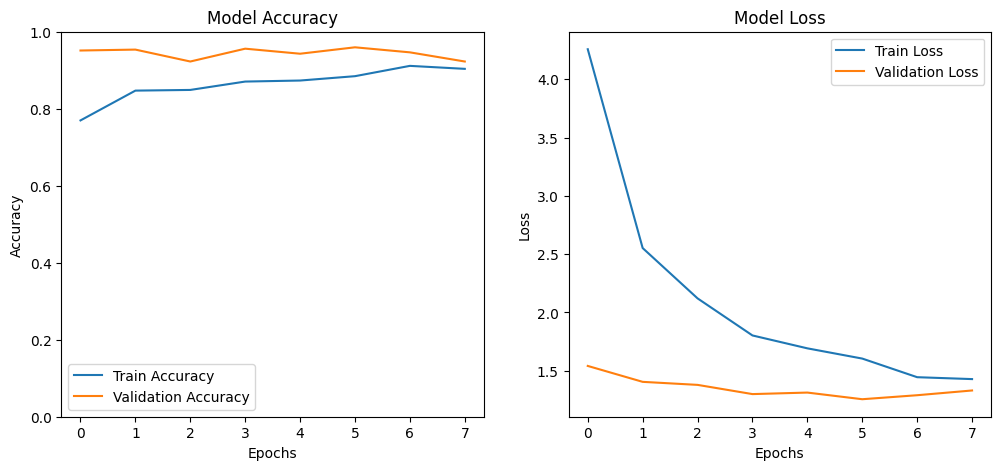

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


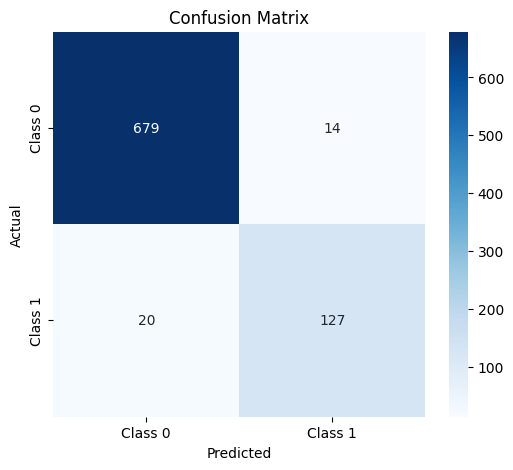

              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       693
     Class 1       0.90      0.86      0.88       147

    accuracy                           0.96       840
   macro avg       0.94      0.92      0.93       840
weighted avg       0.96      0.96      0.96       840



In [2]:
import os
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger('tensorflow').setLevel(logging.FATAL)


DATA_PATH = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/"
BATCH_SIZE = 64  
IMG_HEIGHT_WIDTH = 128 
IMG_INPUT_SHAPE = (IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH, 3)
MAX_EPOCHS = 8  

DS_TRAIN = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH),
    batch_size=BATCH_SIZE
)

DS_VALID = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH),
    batch_size=BATCH_SIZE
)


train_labels = np.concatenate([y for x, y in DS_TRAIN], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))


AUTOTUNE = tf.data.AUTOTUNE
DS_TRAIN = DS_TRAIN.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
DS_VALID = DS_VALID.cache().prefetch(buffer_size=AUTOTUNE)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


def get_vgg16_model():
    base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=IMG_INPUT_SHAPE)
    base_model.trainable = False  
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=IMG_INPUT_SHAPE), 
        data_augmentation,  
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model

VGG16_MODEL = get_vgg16_model()


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True
)


def compile_and_fit(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    history = model.fit(
        DS_TRAIN,
        validation_data=DS_VALID,
        epochs=MAX_EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[early_stopping]  
    )
    return history

VGG16_HISTORY = compile_and_fit(VGG16_MODEL)

test_loss, test_accuracy = VGG16_MODEL.evaluate(DS_VALID)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(VGG16_HISTORY.history['accuracy'], label='Train Accuracy')
plt.plot(VGG16_HISTORY.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1.0])  # Adjust y-axis limits

plt.subplot(1, 2, 2)
plt.plot(VGG16_HISTORY.history['loss'], label='Train Loss')
plt.plot(VGG16_HISTORY.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


actual_labels = []
predicted_labels = []
for images, labels in DS_VALID:
    preds = VGG16_MODEL.predict(images)
    actual_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(preds, axis=1))


cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(actual_labels, predicted_labels, target_names=['Class 0', 'Class 1']))